# TP Programmation avec Keras - Cas MNIST, fonctionnalités avancées

Nous allons produire un réseau de neurones autoencodeur sur la base de données MNIST. L'objectif d'un autoencodeur est d'être capable, à l'aide de la première partie du réseau appelée encodeur, de réduire la dimension des données de manière non linéaire dans un espace appelé espace latent. C'est en quelques sortes une version non linéaire de l'analyse en composantes principales. La deuxième partie du réseau, appelée décodeur, reconstruit les données à partir de l'espace latent.

Dans ce TP, des cellules seront laissées à trous, il faudra les compléter suivant les consignes. Elles seront identifiées par le mot **Exercice**. Les **Vérifications** seront effectuées principalement par vous-mêmes, sur la bonne convergence des algorithmes ou leur bon fonctionnement.

Ci-dessous, on importe les bibliothèques qui seront utiles.

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

## Mise en place des données

Le code ci-dessous charge les données MNIST.

In [127]:
#NE PAS MODIFIER

(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

**Exercice** : Normalisez les données d'entrées en les divisant par 255. Ne vous occupez pas des données de sortie, nous n'en aurons pas besoin.

In [128]:
X_train = X_train/255

X_test = X_test/255

**Exercice** : Nous allons utiliser des couches de convolution à deux dimensions dans cet auto-encodeur. Adaptez les dimensions de X_train de façon à pouvoir utiliser ce type de couche (rappel : il faut trois dimensions).

In [129]:
X_train = np.expand_dims(X_train,axis = 3)

X_test = np.expand_dims(X_test,axis = 3)

## Modèle Keras

### Création du modèle auto-encodeur

**Exercice** : Créez un modèle avec Keras que vous appellerez "my_model".

**Instructions spécifiques** : 
- Utilisez deux/trois couches de convolution dans un premier temps avec des MaxPooling puis un couche de Flatten.
- Passez à deux/trois couches Dense.
- La dernière couche que vous aurez mise ici sera l'espace latent. Le nombre de neurones déterminera la dimension de l'espace latent. Essayez déjà avec deux neurones dans l'espace latent. Donnez-lui le nom "latent_space" avec le mot-clé name dans la couche Dense. Mettez une fonction d'activation "sigmoid" sur le latent_space.
- Faites ensuite la partie décodeur : c'est en quelque sorte un symétrique de l'encodeur.
- Remettez les couches Dense de manière symétrique.
- La dernière couche Dense devra comporter un nombre de neurones identique à ce que donne la première couche Flatten (utilisez model.summary() pour vous aider).
- Effectuez un reshape (keras.layers.Reshape()) dans laquelle vous indiquerez une dimension correspondant à celle des données avant la première couche Flatten.
- Appliquez le symétrique de vos première couches de convolution en remplaçant Conv2D par Conv2DTranspose et les MaxPooling2D par UpSampling2D (opération inverse du MaxPooling : cela augmente la dimension).
- La dimension de sortie devra être la même que la dimension d'entrée : cela signifie que la dernière couche Conv2DTranspose ne devra comporter qu'un seul neurone (un canal). Mettez une fonction d'activation sidgmoide en sortie de la dernière couche (comme on a normalisé les données d'entrée entre 0 et 1).

In [199]:
my_model = keras.Sequential()
my_model.add(keras.layers.Conv2D(16,5,input_shape = (28,28,1),activation = "relu"))

my_model.add(keras.layers.MaxPooling2D(2))

my_model.add(keras.layers.Conv2D(16,5,activation = "relu"))

my_model.add(keras.layers.MaxPooling2D(2))

my_model.add(keras.layers.Flatten()) 

my_model.add(keras.layers.Dense(32,activation = "relu"))

my_model.add(keras.layers.Dense(2,activation = "sigmoid", name = "latent_space"))

my_model.add(keras.layers.Dense(32,activation = "relu"))

my_model.add(keras.layers.Dense(64,activation = "relu"))

my_model.add(keras.layers.Reshape((4,4,4)))

my_model.add(keras.layers.UpSampling2D(2))

my_model.add(keras.layers.Conv2DTranspose(16,5,activation = "relu"))

my_model.add(keras.layers.UpSampling2D(2))

my_model.add(keras.layers.Conv2DTranspose(1,5,activation = "sigmoid"))


**Exercice** : Affichez la structure de votre modèle avec my_model.summary()

In [200]:
my_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 24, 24, 16)        416       
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 12, 12, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 8, 8, 16)          6416      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 256)               0         
                                                                 
 dense_67 (Dense)            (None, 32)              

**Vérification** : Pour l'instant, il suffit qu'il n'y ait pas d'erreur. La dimension de la dernière couche doit être (None,28,28,1), la couche du milieu doit s'appeler "latent_space" et doit comporter 2 neurones (si vous avez choisi deux dimensions pour l'espace latent).

### Compilation du modèle

**Exercice** : Compilez le modèle avec l'optimizer que vous souhaitez. Ici la sortie correspondra aux images que nous aurons mises en entrée : on comparera donc la sortie du réseau de neurones aux images d'entrée. On peut utiliser une loss mean squared error ("mse") ou binary_cross_entropy. Il ne sera pas utile de mettre de métrique.

In [201]:
opt = keras.optimizers.SGD(lr = 0.1)
my_model.compile(optimizer = opt, loss = "mse")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


**Vérification** : De nouveau, s'il n'y a pas d'erreur et que vous avez suivi les instructions, tout devrait bien se passer.

### Mise en place de l'early stopping

**Exercice** : Définissez un early-stopping.

In [202]:
early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 10,restore_best_weights=True)

## L'apprentissage

**Exercice** : Effectuez l'apprentissage avec un jeu de validation, des mini-batchs, l'early-stopping... et stockez l'historique dans une variable. Attention, les données de sortie doivent être X_train ici, tout comme les données d'entrée !

In [203]:
learning = my_model.fit(X_train,X_train,epochs = 50, batch_size = 128,validation_split = 0.1,callbacks = [early_stopping])

Epoch 1/50
422/422 [==============================] - 5s 11ms/step - loss: 0.1129 - val_loss: 0.0994
Epoch 2/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0930 - val_loss: 0.0819
Epoch 3/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0755 - val_loss: 0.0718
Epoch 4/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0702 - val_loss: 0.0689
Epoch 5/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0678 - val_loss: 0.0667
Epoch 6/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0658 - val_loss: 0.0648
Epoch 7/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0639 - val_loss: 0.0629
Epoch 8/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0621 - val_loss: 0.0614
Epoch 9/50
422/422 [==============================] - 4s 11ms/step - loss: 0.0609 - val_loss: 0.0605
Epoch 10/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0601 - val_lo

**Vérification** : La loss function devrait diminuer. De même pour le jeu de validation.

**Exercice** : Tracez l'évolution de la fonction de coût et de l'accuracy pour le jeu d'entraînement et pour le jeu de validation.

Text(0.5, 1.0, 'Loss function evolution')

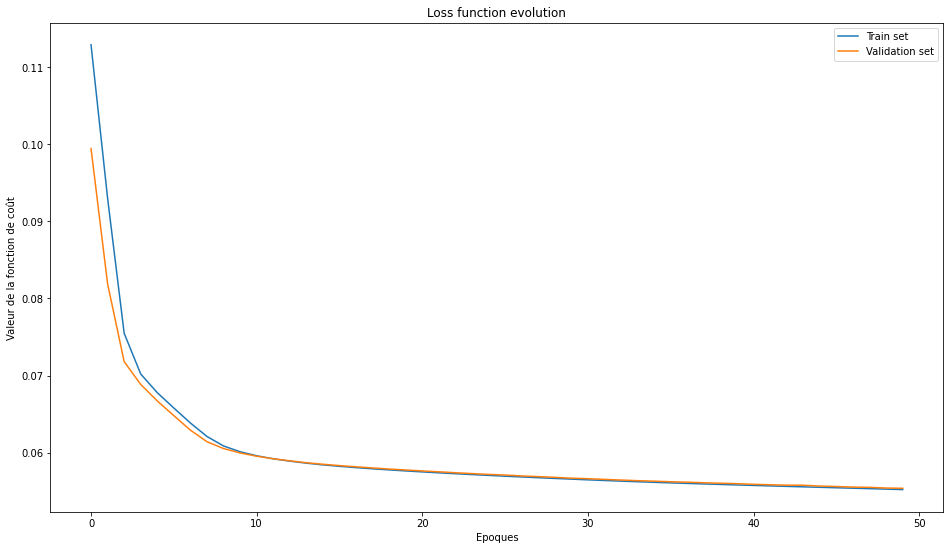

In [204]:
loss_evolution = learning.history["loss"]
val_loss_evolution = learning.history["val_loss"]


plt.figure(figsize = (16,9))
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epoques")
plt.ylabel("Valeur de la fonction de coût")
plt.legend()
plt.title("Loss function evolution")

## Prédictions avec le modèle

**Exercice** : Effectuez la prédiction sur le jeu de test. Notez-la X_pred_test.

In [205]:
X_pred_test = my_model.predict(X_test)

**Exercice** : Affichez ci-dessous un exemple de X_test et X_pred_test.

Text(0.5, 1.0, 'Exemple reconstruit')

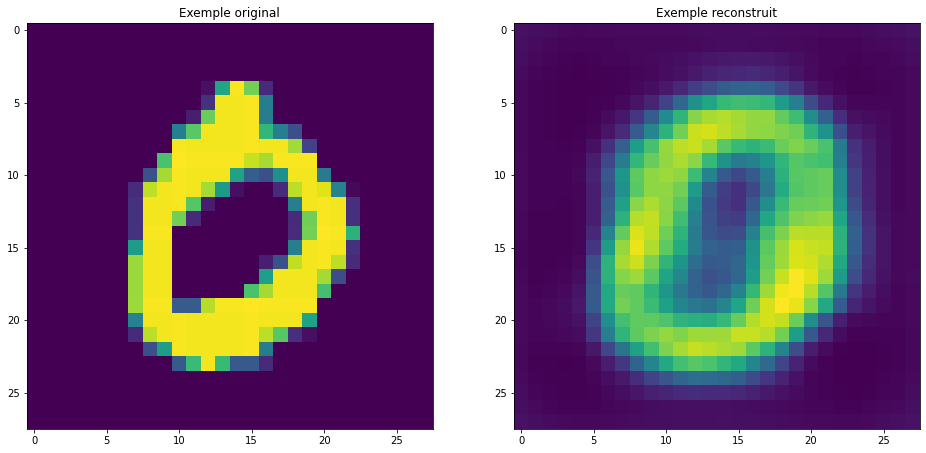

In [206]:
i = 3

plt.figure(figsize = (16,9))

plt.subplot(121)
plt.imshow(X_test[i,:,:,0])
plt.title("Exemple original")

plt.subplot(122)
plt.imshow(X_pred_test[i,:,:,0])
plt.title("Exemple reconstruit")

Vous pourrez voir que les données ne sont pas parfaitement reconstruites : les dimensions de l'espace latent ne sont pas suffisantes pour reconstruire l'ensemble des données, mais cela devrait être déjà assez correct. Nous règlerons cela plus tard. Nous allons étudier un peu plus en détail cet espace latent.

## Représentation de l'espace latent

**Exercice** : Récupérez les sorties de l'espace latent. Pour ce faire, il faut créer un modèle spécifique qui fournit la sortie de l'espace latent. Complétez le code ci-dessous en donnant le nom de la couche que vous voulez extraire. Vous verrez ensuite que le modèle construit correspond à un modèle avec les mêmes inputs que votre autoencodeur, mais en sortie, il prend la couche de l'espace latent.

In [207]:
layer_name = 'latent_space'
latent_space_model = keras.Model(inputs=my_model.input,
                                 outputs=my_model.get_layer(layer_name).output)


**Exercice** : Appliquez ce modèle aux données de test pour prédire les variables de l'espace latent associé.

In [208]:
latent_space_pred = latent_space_model.predict(X_test)

**Exercice** : On a choisi deux dimensions dans l'espace latent afin de pouvoir les représenter facilement visuellement. À l'aide de plt.scatter, affichez les points correspondant à l'espace latent. Donnez leur une couleur correspondant à leur label à l'aide de Y_test (mot-clé : c = Vecteur de couleurs).

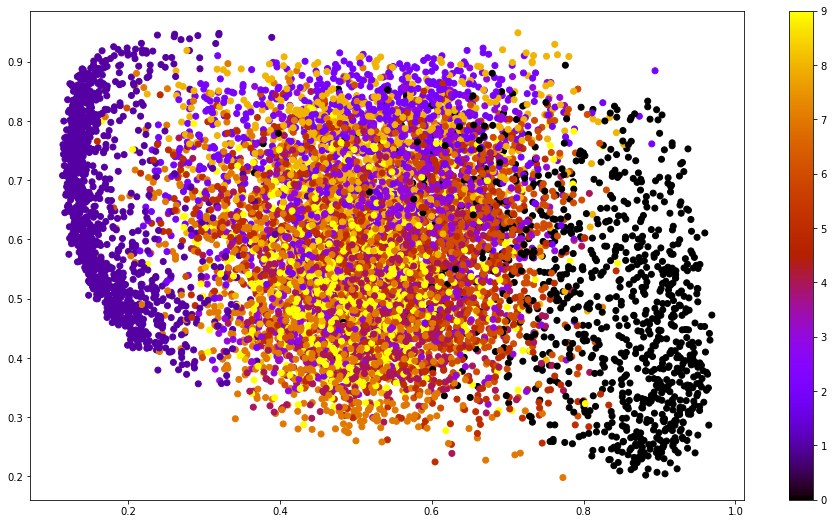

In [209]:
plt.figure(figsize = (16,9))

plt.scatter(latent_space_pred[:,0],latent_space_pred[:,1],c = Y_test, cmap = "gnuplot")
plt.colorbar()

Vous devriez observer que les points se rassemblent par clusters. Ils ne sont pas forcément très bien séparés mais ils sont visibles. Les 0 et 1 devraient par exemple être bien à l'écart des autres.

## Meilleure reconstruction

**Exercice** : Reprenez la structure de l'autoencodeur, mais changez la dimension de l'espace latent de sorte à mieux reconstruire les données avec votre autoencodeur. Une dimension de 10 devrait être suffisante. Donnez un nom à la couche qui suit celle de l'espace latent, par exemple "first_layer_decod". Relancez l'ensemble de l'apprentissage. 

In [211]:
my_model_2 = keras.Sequential()
my_model_2.add(keras.layers.Conv2D(4,5,input_shape = (28,28,1),activation = "relu"))

my_model_2.add(keras.layers.MaxPooling2D(2))

my_model_2.add(keras.layers.Conv2D(4,5,activation = "relu"))

my_model_2.add(keras.layers.MaxPooling2D(2))

my_model_2.add(keras.layers.Flatten()) 

my_model_2.add(keras.layers.Dense(32,activation = "relu"))

my_model_2.add(keras.layers.Dense(10,activation = "sigmoid", name = "latent_space"))

my_model_2.add(keras.layers.Dense(32,activation = "relu", name = "first_layer_decod"))

my_model_2.add(keras.layers.Dense(64,activation = "relu"))

my_model_2.add(keras.layers.Reshape((4,4,4)))

my_model_2.add(keras.layers.UpSampling2D(2))

my_model_2.add(keras.layers.Conv2DTranspose(4,5,activation = "relu"))

my_model_2.add(keras.layers.UpSampling2D(2))

my_model_2.add(keras.layers.Conv2DTranspose(4,5,activation = "relu"))

my_model_2.add(keras.layers.Conv2D(1,5,activation = "sigmoid",padding = "same"))



opt = keras.optimizers.Adam(lr = 0.001)
my_model_2.compile(optimizer = opt, loss = "mse")

learning_2 = my_model_2.fit(X_train,X_train,epochs = 50, batch_size = 128,validation_split = 0.1,callbacks = [early_stopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
422/422 [==============================] - 6s 12ms/step - loss: 0.0826 - val_loss: 0.0610
Epoch 2/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0552 - val_loss: 0.0501
Epoch 3/50
422/422 [==============================] - 6s 14ms/step - loss: 0.0461 - val_loss: 0.0424
Epoch 4/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0405 - val_loss: 0.0380
Epoch 5/50
422/422 [==============================] - 5s 11ms/step - loss: 0.0360 - val_loss: 0.0344
Epoch 6/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0333 - val_loss: 0.0323
Epoch 7/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0318 - val_loss: 0.0309
Epoch 8/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0308 - val_loss: 0.0300
Epoch 9/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0300 - val_loss: 0.0295
Epoch 10/50
422/422 [==============================] - 5s 12ms/step - loss: 0.0295 - val_lo

**Exercice** : Affichez les graphes des fonctions de coût.

Text(0.5, 1.0, 'Loss function evolution')

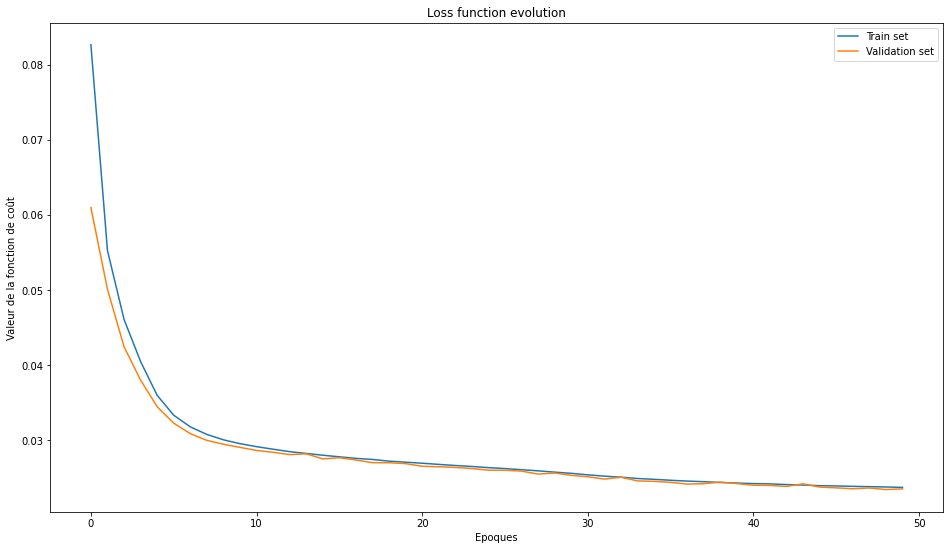

In [212]:
loss_evolution = learning_2.history["loss"]
val_loss_evolution = learning_2.history["val_loss"]

plt.figure(figsize = (16,9))
plt.plot(loss_evolution,label = "Train set")
plt.plot(val_loss_evolution,label = "Validation set")
plt.xlabel("Epoques")
plt.ylabel("Valeur de la fonction de coût")
plt.legend()
plt.title("Loss function evolution")

**Exercice** : Effectuez la prédiction sur vos données de test.

In [213]:
X_pred_test = my_model_2.predict(X_test)

**Exercice** : Représentez quelques exemples que vous avez reconstruit et comparez-les aux exemples originaux.

Text(0.5, 1.0, 'Exemple reconstruit')

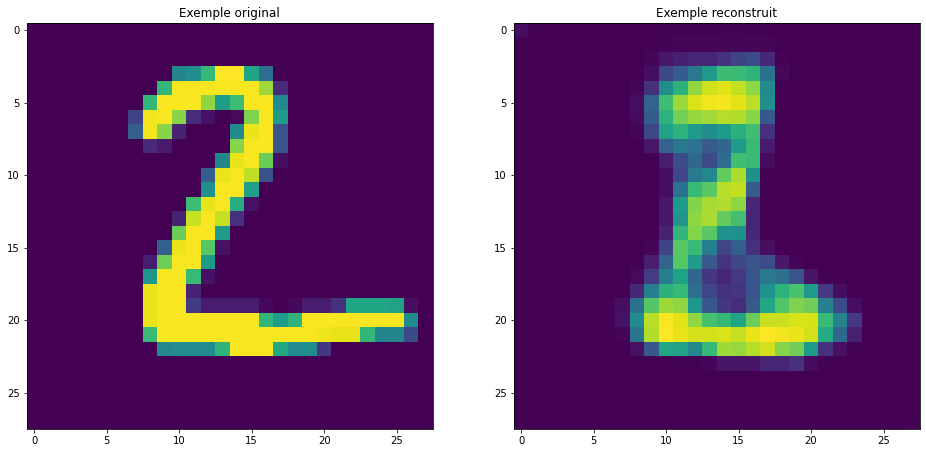

In [214]:
i = 1
plt.figure(figsize = (16,9))

plt.subplot(121)
plt.imshow(X_test[i,:,:,0])
plt.title("Exemple original")

plt.subplot(122)
plt.imshow(X_pred_test[i,:,:,0])
plt.title("Exemple reconstruit")

### Débruitage d'image

**Exercice** : Nous allons appliquer votre autoencodeur au débruitage d'image. Sélectionnez une image de test. Ajoutez-lui un bruit gaussien avec np.random.randn(), précisez la dimension du bruit à ajouter. Utilisez un écart-type de 0.1 pour commencer. Effectuez un np.clip sur votre image bruitée pour que les valeurs soient bien comprises entre 0 et 1. Enfin, appliquez-lui votre auto-encodeur. Vous pourrez vous amuser à modifier l'écart-type.

Text(0.5, 1.0, 'Image débruitée')

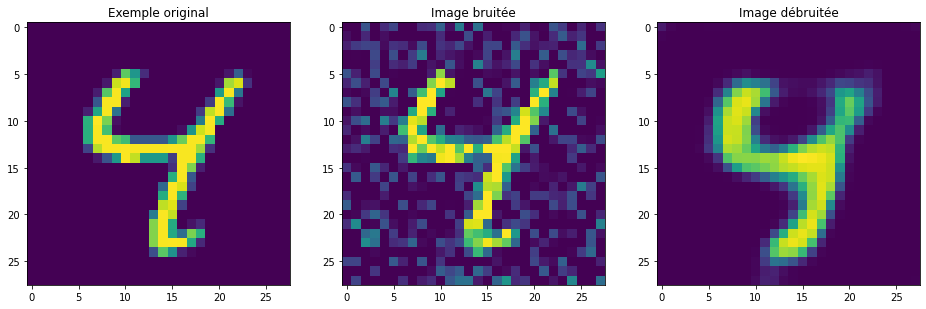

In [215]:
i = 6

image = X_test[i:(i+1)]

image_noisy = image + 0.2*np.random.randn(1,28,28,1)
image_noisy = np.clip(image_noisy,0.,1.)

image_denoised = my_model_2.predict(image_noisy)

plt.figure(figsize = (16,9))

plt.subplot(131)
plt.imshow(image[0,:,:,0])
plt.title("Exemple original")

plt.subplot(132)
plt.imshow(image_noisy[0,:,:,0])
plt.title("Image bruitée")

plt.subplot(133)
plt.imshow(image_denoised[0,:,:,0])
plt.title("Image débruitée")

### Interpolation dans l'espace latent

**Exercice** : Complétez le code ci-dessous pour séparer la partie encodeur et décodeur.

In [216]:
layer_name = 'latent_space'
encoder = keras.Model(inputs=my_model_2.input,
                                 outputs=my_model_2.get_layer(layer_name).output)

layer_name_2 = "first_layer_decod"
decoder = keras.Model(inputs=my_model_2.get_layer(layer_name_2).input,
                                 outputs=my_model_2.output)

**Exercice** : Choisissez deux images et appliquez-leur la partie encodeur, sauvegardez les variables latente correspondantes. N'utilisez pas predict, appliquez directement encoder comme ceci : encoder(image).

In [222]:
i_1 = 0
i_2 = 102

image_1 = X_test[i_1:i_1+1]
image_2 = X_test[i_2:i_2+1]

lat_1 = encoder(image_1)
lat_2 = encoder(image_2)

**Exercice** : Effectuez une interpolation entre les variables latentes de la manière suivante : $lat_{interp} = (1 - \lambda lat_1) + \lambda lat_2$ avec $\lambda$ variant de 0 à 1 avec 10 de valeurs.

In [223]:
lambd = tf.linspace(0,1,10)
lambd = tf.cast(lambd,dtype = "float32")
lambd = tf.reshape(lambd,(10,1))

lambd = tf.repeat(lambd,10,axis = 1)
lat_1 = tf.repeat(lat_1,10,axis = 0)
lat_2 = tf.repeat(lat_2,10,axis = 0)

lat_interp = lat_1*(1-lambd) + lat_2*lambd

**Exercice** : Appliquez votre décodeur sur les variables lat_interp.

In [224]:
im_interp = decoder(lat_interp)

Ci-dessous, on représente les images interpolées par votre décodeur !

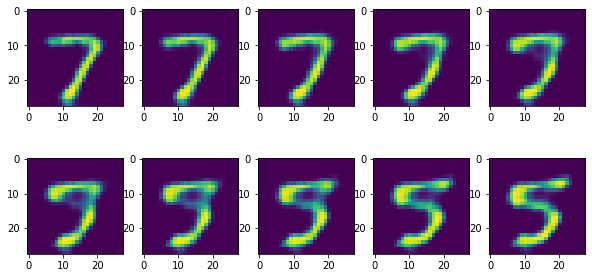

In [226]:
plt.figure(figsize = (10,5))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(im_interp[i,:,:,0])